# Gillespie Implementation using Pyro

In [200]:
import pyro
import torch

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

## Lotka-Volterra Application

### Unvectorized Loop Model (used for data gen)

True Rates:

In [12]:
## Define Model
def lotka_volterra_sampling(data):
    
    collect = list()
    
    num_sequences, max_length, data_dim = data.shape
    
    ## Define true rates
    rates = torch.tensor([.9, .015, .35])
    
    # print(rates)
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([50., 100.])
        
        temp_list = list()
        
        for t in pyro.markov(torch.arange(max_length)):
            
            ## Calculate reaction rates
            reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                           rates[0] * s_start[0])
            reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                           rates[1] * s_start[0] * s_start[1])
            reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                           rates[2] * s_start[1])

            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 0)

            # Sample
            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        #infer={"enumerate": "parallel"},
                    )

            ## Update tensor
            transition = torch.tensor([[ 1,  0],
                              [-1,  1],
                              [ 0, -1]])            
            update = transition[x]
            # print(update)
            with sample_plate:
                ## Observed sample
                sample = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    # obs=data[i, t]
                )
                temp_list.append(sample)

            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), 
                                         torch.maximum(torch.tensor([1., 1.]), s_start + update), 
                                         event_dim=1)

        collect.append(torch.stack(temp_list))
    return collect


In [14]:
lv_data_temp = lotka_volterra_sampling(torch.zeros(100, 100, 2))
lv_data = torch.stack(lv_data_temp)
lv_data[0, :10]

tensor([[ 51.0129,  99.9986],
        [ 51.9984,  99.9938],
        [ 53.0036,  99.9993],
        [ 52.0002, 101.0032],
        [ 51.9847, 100.0074],
        [ 53.0007, 100.0146],
        [ 53.9928, 100.0045],
        [ 55.0139, 100.0025],
        [ 55.9980,  99.9946],
        [ 56.0040,  99.0063]])

In [259]:
with open('../data/lv_data.pickle', 'wb') as handle:
    pickle.dump(temp, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Confirm data makes sense

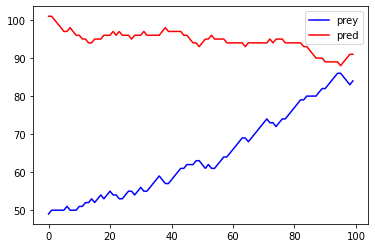

In [15]:
fig, ax = plt.subplots()

ax.plot(np.arange(lv_data.shape[1]), lv_data[1, :, 0], color = "blue", label = "prey")
ax.plot(np.arange(lv_data.shape[1]), lv_data[1, :, 1], color = "red", label = "pred")
plt.legend()

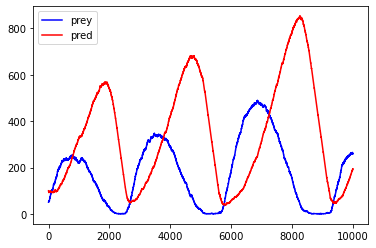

In [16]:
lv_data_temp = lotka_volterra_sampling(torch.zeros(1, 10000, 2))
lv_data_long = torch.stack(lv_data_temp)
lv_data_long[0, :10]

fig, ax = plt.subplots()

ax.plot(np.arange(lv_data_long.shape[1]), lv_data_long[0, :, 0], color = "blue", label = "prey")
ax.plot(np.arange(lv_data_long.shape[1]), lv_data_long[0, :, 1], color = "red", label = "pred")

plt.legend()

### Vectorized Model

True Rates: [ .9, .015, .35 ]

Priors: [ .9, .05, .4 ]

In [ ]:
def lotka_volterra_1(data):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.105, -2.996, -.916]), .1).to_event(1),#[-.15, -6., -1.5][-.15, -4., -1.]
    )

    ## Starting points
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, dim = -2) as batch:

        s_start = torch.tensor([[[50., 100.]]])
        for t in pyro.markov(range(max_length)):

            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(torch.stack([rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0], 
                                                                rates[1] * pyro.ops.indexing.Vindex(s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1], 
                                                                rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1]],
                                                               axis = 1).squeeze(-1)),
            )

            transition = torch.tensor([[ 1,  0],
                  [-1,  1],
                  [ 0, -1]])
            update = transition[x]

            with sample_plate:

                pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)


In [ ]:
## Define Model
def lotka_volterra_guide(data):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates_0 = pyro.param("rates_0", torch.tensor([.9,.05,.4]),
                             constraint=torch.distributions.constraints.positive)
    rates = pyro.sample(
        "rates",
        pyro.distributions.Delta(rates_0).to_event(1),
    )

    ## Starting points
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, dim = -2) as batch:

        s_start = torch.tensor([[[50., 100.]]])
        for t in pyro.markov(range(max_length)):

            #with sample_plate:
            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(torch.stack([rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0], 
                                                                rates[1] * pyro.ops.indexing.Vindex(
                                                                    s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1], 
                                                                rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1]],
                                                               axis = 1).squeeze(-1)),
                    infer={"enumerate": "sequential"},
            )

### Confirm that model compiles

In [ ]:
lv_data_temp = lotka_volterra_sampling(torch.zeros(10, 5, 2))
lv_data = torch.stack(lv_data_temp)

In [ ]:
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)#
elbo.loss(lotka_volterra_1, lotka_volterra_guide, temp) ## Ensure model compiles

## Infer Rates

### Inference

In [32]:
def infer_rates(model, guide, learning_rate=.001, num_steps = 1000, beta0=.9, beta1=.99):
    
    pyro.clear_param_store()
    
    ## Setup Model Params
    elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
    optim = pyro.optim.Adam({"lr": learning_rate, "betas" : (beta0, beta1)})
    svi = pyro.infer.SVI(model, guide, optim, elbo)
    
    rates_tracker = list()
    loss_tracker = list()
    for step in range(num_steps):
        svi.step(observations)
        loss_tracker.append(svi.evaluate_loss(observations))
        for key, value in pyro.get_param_store().items():
            rates_tracker.append(value)

    
    rates_tracker = np.array([x.detach().numpy() for x in rates_tracker])
    return rates_tracker, loss_tracker


In [43]:
lv_data_temp = lotka_volterra_sampling(torch.zeros(10, 5, 2))
lv_data = torch.stack(lv_data_temp)

In [ ]:
rate_results = infer_rates(lotka_volterra_1, lotka_volterra_guide, lv_data, learning_rate=.01, num_steps = 1000)

/home/dkohler/anaconda3/lib/python3.9/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'x_0_64', 'x_71_58', 'x_12_43', 'x_51_52', 'x_67_63', 'x_71_38', 'x_93_42', 'x_97_61', 'x_40_52', 'x_8_52', 'x_79_53', 'x_50_59', 'x_88_29', 'x_1_60', 'x_95_61', 'x_84_73', 'x_84_41', 'x_13_71', 'x_29_30', 'x_10_57', 'x_77_32', 'x_53_86', 'x_47_24', 'x_99_40', 'x_0_4', 'x_49_38', 'x_65_11', 'x_53_16', 'x_50_20', 'x_71_59', 'x_51_17', 'x_55_69', 'x_98_53', 'x_92_26', 'x_19_87', 'x_2_51', 'x_63_66', 'x_76_18', 'x_5_59', 'x_23_42', 'x_93_71', 'x_75_76', 'x_40_39', 'x_86_66', 'x_52_8', 'x_30_49', 'x_21_73', 'x_93_66', 'x_38_72', 'x_68_59', 'x_75_62', 'x_71_49', 'x_20_1', 'x_39_83', 'x_66_17', 'x_86_55', 'x_17_6', 'x_54_96', 'x_94_86', 'x_30_26', 'x_1_99', 'x_79_14', 'x_51_92', 'x_66_5', 'x_49_71', 'x_49_81', 'x_96_35', 'x_87_49', 'x_56_73', 'x_14_61', 'x_12_21', 'x_95_45', 'x_2_80', 'x_57_23', 'x_4_66', 'x_40_91', 'x_36_8', 'x_10_4', 'x_31_80', 'x_5_52', 'x_79_89', 'x_36_1

#### With bad priors : .9, .3, .7

True rates:  [ .9, .015, .35 ]

In [17]:
loss = np.array([691468.0650115013, 670521.465144515, 646260.9688317776, 618265.590899229, 586548.1366419792,
                551873.916841507, 516014.1296849251, 481703.79737758636, 452045.583524704, 429378.5150299072,
                414242.46589660645, 405307.2240142822, 400363.3226928711, 397473.473236084, 395474.75326538086, 
                393856.9665527344, 392456.2741088867, 391236.37268066406, 390189.1943359375, 389305.2114868164, 
                388569.32849121094, 387962.4634399414, 387465.7897338867, 387061.17764282227, 386732.04095458984,
                386464.5118713379, 386247.3483886719, 386070.51960754395, 385926.5041656494, 385809.4211730957, 
                385713.8262023926, 385635.678024292, 385571.72982788086, 385519.5032348633, 385476.7055358887, 
                385441.94638061523, 385413.2445678711, 385389.4839782715, 385370.22270202637, 385354.5023345947, 
                385341.55506134033, 385330.8786087036, 385322.1106414795, 385314.92069244385, 385309.1728515625, 
                385304.3779067993, 385300.5311126709, 385297.2459869385])
rates = np.array([[0.9090, 0.2970, 0.7070], [1.0052, 0.2686, 0.7818], [1.1141, 0.2424, 0.8663], [1.2393, 0.2180, 0.9632], [1.3841, 0.1953, 1.0744], 
                 [1.5514, 0.1745, 1.2015], [1.7427, 0.1557, 1.3442], [1.9577, 0.1391, 1.4993], [2.1930, 0.1250, 1.6596], [2.4417, 0.1134, 1.8128], 
                 [2.6947, 0.1044, 1.9432], [2.9420, 0.0977, 2.0364], [3.1763, 0.0930, 2.0852], [3.3936, 0.0899, 2.0921], [3.5936, 0.0879, 2.0667], 
                 [3.7778, 0.0868, 2.0209], [3.9484, 0.0862, 1.9649], [4.1074, 0.0859, 1.9057], [4.2560, 0.0858, 1.8476], [4.3948, 0.0857, 1.7926],
                 [4.5238, 0.0858, 1.7417], [4.6426, 0.0859, 1.6950], [4.7513, 0.0860, 1.6524], [4.8500, 0.0862, 1.6137], [4.9390, 0.0864, 1.5786], 
                 [5.0192, 0.0866, 1.5468], [5.0912, 0.0868, 1.5180], [5.1561, 0.0871, 1.4920], [5.2144, 0.0873, 1.4684], [5.2671, 0.0875, 1.4472], 
                 [5.3147, 0.0877, 1.4279], [5.3576, 0.0878, 1.4105], [5.3965, 0.0880, 1.3947], [5.4316, 0.0881, 1.3803], [5.4634, 0.0883, 1.3673], 
                 [5.4921, 0.0884, 1.3554], [5.5180, 0.0885, 1.3446], [5.5414, 0.0886, 1.3348], [5.5624, 0.0887, 1.3259], [5.5814, 0.0888, 1.3177], 
                 [5.5984, 0.0889, 1.3102], [5.6136, 0.0889, 1.3034], [5.6273, 0.0890, 1.2972], [5.6394, 0.0890, 1.2915], [5.6503, 0.0891, 1.2863], 
                 [5.6598, 0.0891, 1.2815], [5.6683, 0.0891, 1.2772], [5.6757, 0.0892, 1.2732]])

In [18]:
rates

array([[0.909 , 0.297 , 0.707 ],
       [1.0052, 0.2686, 0.7818],
       [1.1141, 0.2424, 0.8663],
       [1.2393, 0.218 , 0.9632],
       [1.3841, 0.1953, 1.0744],
       [1.5514, 0.1745, 1.2015],
       [1.7427, 0.1557, 1.3442],
       [1.9577, 0.1391, 1.4993],
       [2.193 , 0.125 , 1.6596],
       [2.4417, 0.1134, 1.8128],
       [2.6947, 0.1044, 1.9432],
       [2.942 , 0.0977, 2.0364],
       [3.1763, 0.093 , 2.0852],
       [3.3936, 0.0899, 2.0921],
       [3.5936, 0.0879, 2.0667],
       [3.7778, 0.0868, 2.0209],
       [3.9484, 0.0862, 1.9649],
       [4.1074, 0.0859, 1.9057],
       [4.256 , 0.0858, 1.8476],
       [4.3948, 0.0857, 1.7926],
       [4.5238, 0.0858, 1.7417],
       [4.6426, 0.0859, 1.695 ],
       [4.7513, 0.086 , 1.6524],
       [4.85  , 0.0862, 1.6137],
       [4.939 , 0.0864, 1.5786],
       [5.0192, 0.0866, 1.5468],
       [5.0912, 0.0868, 1.518 ],
       [5.1561, 0.0871, 1.492 ],
       [5.2144, 0.0873, 1.4684],
       [5.2671, 0.0875, 1.4472],
       [5.

Text(0.5, 0, 'steps')

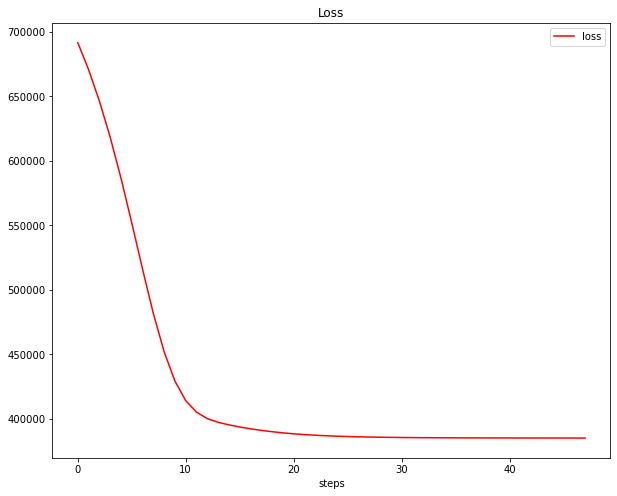

In [26]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(np.arange(0,48), loss, color = "red", label = "loss")

plt.legend()
ax.set_title("Loss")
ax.set_xlabel("steps")

Text(0.5, 0, 'steps')

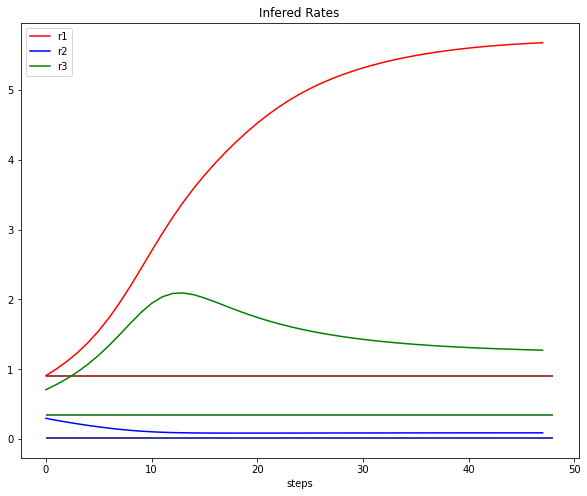

In [27]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(np.arange(0,48), rates[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,48), rates[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,48), rates[:, 2], color = "green", label = "r3")

ax.hlines(y = .9, xmin = 0, xmax = 48, color = "darkred")
ax.hlines(y = .015, xmin = 0, xmax = 48,color = "navy")
ax.hlines(y = .35, xmin = 0, xmax = 48,color = "darkgreen")

plt.legend()
ax.set_title("Infered Rates")
ax.set_xlabel("steps")

Why did it not converge to the correct values:
1. (Very) low replicates (2)
2. (Very) low steps (5)
3. Bad priors

#### With bad priors : .9, .05, .4, and more replicates (10)

True rates:  [ .9, .015, .35 ]

In [28]:
loss = np.array([1958518.2779693604, 1880021.4254760742, 1829479.6990356445, 1807661.7854614258, 1801638.1197509766, 
                 1798100.5393676758, 1794205.083557129, 1791088.7697143555, 1788878.5608520508, 1787259.3004760742, 
                 1786086.9563293457, 1785264.33303833, 1784683.2415771484, 1784275.1806030273, 1783988.8352966309, 
                 1783790.7803955078, 1783651.7004699707, 1783555.1278381348, 1783489.988494873, 1783443.8989868164, 
                 1783413.990600586, 1783392.951599121, 1783378.2848205566, 1783368.5862503052, 1783362.9032211304, 
                 1783358.122970581, 1783356.4904251099, 1783353.5543670654, 1783352.9811096191, 1783352.410583496, 
                 1783351.5933380127, 1783352.013534546, 1783350.7700805664, 1783351.828338623, 1783351.6425628662, 
                 1783351.5021514893, 1783351.6183242798])

rates = np.array([[0.9090, 0.0495, 0.4040], [1.0038, 0.0448, 0.4458], [1.1028, 0.0409, 0.4863], [1.1968, 0.0380, 0.5145], 
                  [1.2745, 0.0363, 0.5182], [1.3306, 0.0357, 0.4994], [1.3703, 0.0357, 0.4712], [1.4037, 0.0359, 0.4442], 
                  [1.4375, 0.0361, 0.4220], [1.4722, 0.0360, 0.4046], [1.5047, 0.0360, 0.3903], [1.5323, 0.0360, 0.3780], 
                  [1.5545, 0.0360, 0.3674], [1.5725, 0.0361, 0.3584], [1.5879, 0.0361, 0.3508], [1.6013, 0.0362, 0.3445], 
                  [1.6127, 0.0362, 0.3393], [1.6223, 0.0363, 0.3349], [1.6303, 0.0363, 0.3312], [1.6370, 0.0363, 0.3281],
                  [1.6426, 0.0363, 0.3255], [1.6474, 0.0364, 0.3234], [1.6513, 0.0364, 0.3216], [1.6545, 0.0364, 0.3202], 
                  [1.6572, 0.0364, 0.3190], [1.6593, 0.0364, 0.3180], [1.6611, 0.0364, 0.3172], [1.6626, 0.0364, 0.3165],
                  [1.6638, 0.0364, 0.3160], [1.6647, 0.0364, 0.3156], [1.6654, 0.0364, 0.3152], [1.6660, 0.0364, 0.3150], 
                  [1.6665, 0.0364, 0.3148], [1.6669, 0.0364, 0.3146], [1.6671, 0.0364, 0.3145], [1.6673, 0.0364, 0.3144], [1.6675, 0.0365, 0.3143]])


Text(0.5, 0, 'steps')

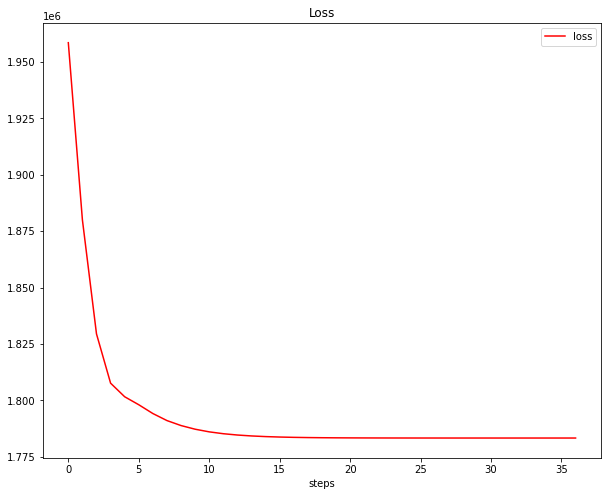

In [30]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(np.arange(0,37), loss, color = "red", label = "loss")

plt.legend()
ax.set_title("Loss")
ax.set_xlabel("steps")

Text(0.5, 0, 'steps')

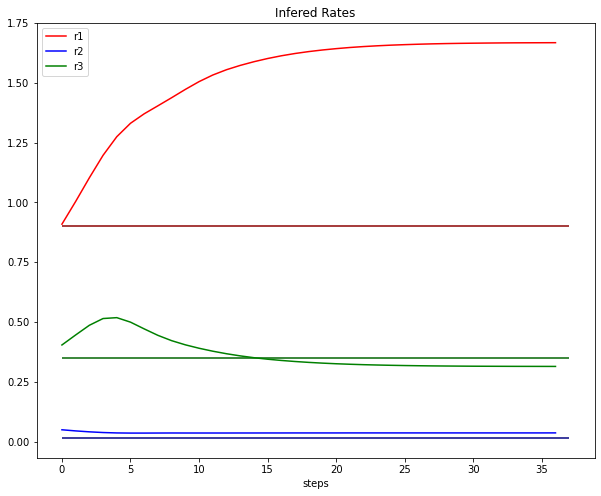

In [31]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(np.arange(0,37), rates[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,37), rates[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,37), rates[:, 2], color = "green", label = "r3")

ax.hlines(y = .9, xmin = 0, xmax = 37, color = "darkred")
ax.hlines(y = .015, xmin = 0, xmax = 37,color = "navy")
ax.hlines(y = .35, xmin = 0, xmax = 37,color = "darkgreen")

plt.legend()
ax.set_title("Infered Rates")
ax.set_xlabel("steps")

Looks better but still off. Most likely still an issue with the # of timesteps.

### Next Steps

1. Get parallel enumeration working
2. Get Lotka Volterra rates to converge to correct values
3. Add time to Lotka Volterra model
4. Apply model to Lac Operon
    1. Make sure rates can still converge with all steps observed
    2. Adjust model to only observe certain steps (as in real life)
5. Test experimental design conditions with differing number of replicates and observations
6. Find real data and apply it to the model

### Data generation model with time component

Define parameters and data used for Proppa

In [195]:
## Define Model
def lotka_volterra_sampling(data):
    
    collect_samples = list()
    
    num_sequences, max_length, data_dim = data.shape
    
    ## Define true rates
    rates = torch.tensor([.0009, .000015, .00035])
    
    # print(rates)
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([20., 40., 0.])
        
        time = torch.tensor(0.)
        temp_species_list = [s_start]
        
        for t in pyro.markov(torch.arange(max_length)):
            
            ## Calculate reaction rates
            reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                           rates[0] * s_start[0])
            reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                           rates[1] * s_start[0] * s_start[1])
            reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                           rates[2] * s_start[1])

            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 0)

            # Sample
            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        #infer={"enumerate": "parallel"},
                    )

            ## Update tensor
            transition = torch.tensor([[ 1,  0, 0],
                              [-1,  1,0],
                              [ 0, -1,0]])            
            update = transition[x]
            # print(update)
            with sample_plate:
                ## Observed sample
                sample = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    # obs=data[i, t]
                )


            time_sample = pyro.sample(
                    "time_{}_{}".format(t, i),
                    pyro.distributions.Exponential(sum(s_start + update)),
                    # obs=data[i, t]
                )
            
            combo_list = list()
            
            time += time_sample  
            append_val = torch.cat((sample[:-1], torch.tensor([time])))
            temp_species_list.append(append_val)
            
            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), 
                                         torch.maximum(torch.tensor([1., 1.,0.]), s_start + update), 
                                         event_dim=1)
            
            
        collect_samples.append(torch.stack(temp_species_list))
    return collect_samples


In [196]:
lv_data_temp = lotka_volterra_sampling(torch.zeros(10, 10000, 3))
lv_data_samples = torch.stack(lv_data_temp)
# lv_data[0, :10]

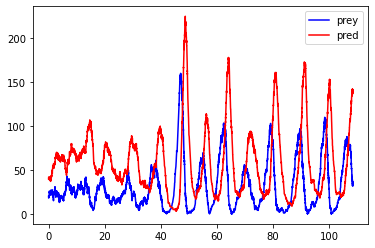

In [198]:
fig, ax = plt.subplots()

ax.plot(lv_data_samples[0, :, 2], lv_data_samples[0, :, 0], color = "blue", label = "prey")
ax.plot(lv_data_samples[0, :, 2], lv_data_samples[0, :, 1], color = "red", label = "pred")

plt.legend()

In [212]:
np.array(lv_data_samples[0])

array([[2.0000000e+01, 4.0000000e+01, 0.0000000e+00],
       [1.8983036e+01, 4.1000755e+01, 2.8073801e-02],
       [1.8005167e+01, 4.2004864e+01, 4.3379847e-02],
       ...,
       [3.2993965e+01, 1.4099678e+02, 1.0837571e+02],
       [3.3001484e+01, 1.4001086e+02, 1.0837627e+02],
       [3.2007591e+01, 1.4100348e+02, 1.0838406e+02]], dtype=float32)

In [217]:
df = pd.DataFrame(np.array(lv_data_samples[0]), columns = ["X", "Y", "time"])
df.loc[[x for x in range(len(df)) if x%100 == 0], ["time", "X", "Y"]
      ].to_csv("../data/lv_proppa_obs", sep = " ", index = False)

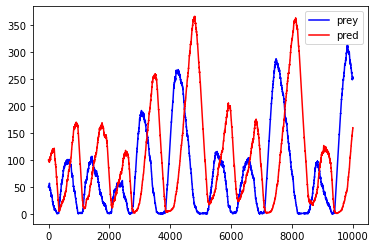

In [192]:
fig, ax = plt.subplots()

ax.plot(np.arange(lv_data_samples.shape[1]), lv_data_samples[3, :, 0], color = "blue", label = "prey")
ax.plot(np.arange(lv_data_samples.shape[1]), lv_data_samples[3, :, 1], color = "red", label = "pred")

plt.legend()

In [ ]:
with open('../data/lv_data.pickle', 'wb') as handle:
    pickle.dump(temp, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Old models and code.. 
TODO: Figure out what should be kept/deleted

### Try some different data sizes

In [38]:
## Define Model
def lotka_volterra_0(data):
    
    collect = list()
    
    num_sequences, max_length, data_dim = data.shape
    
    ## Define true rates
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([0., 0., 0.]), .1).to_event(1),
    )
    # print(rates)
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    test_plate = pyro.plate("test")
    for i in pyro.plate("sequences", num_sequences):
        
        s_start = torch.tensor([50., 100.])
        
        temp_list = list()
        
        for t in pyro.markov(torch.arange(max_length)):
            
            ## Calculate reaction rates
            reaction1 = pyro.deterministic("reaction1_{}_{}".format(t, i),
                                           rates[0] * s_start[0])
            reaction2 = pyro.deterministic("reaction2_{}_{}".format(t, i),
                                           rates[1] * s_start[0] * s_start[1])
            reaction3 = pyro.deterministic("reaction3_{}_{}".format(t, i),
                                           rates[2] * s_start[1])

            rates_matrix = torch.stack([reaction1, reaction2, reaction3], axis = 0)

            # Sample
            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates_matrix),
                        #infer={"enumerate": "parallel"},
                    )

            ## Update tensor
            transition = torch.tensor([[ 1,  0],
                              [-1,  1],
                              [ 0, -1]])            
            update = transition[x]
            # print(update)
            with sample_plate:
                ## Observed sample
                sample = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[i, t]
                )
                temp_list.append(sample)

            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), 
                                         torch.maximum(torch.tensor([1, 1]), s_start + update), 
                                         event_dim=1)

        collect.append(torch.stack(temp_list))
    return collect


#### 20 reps, 100 steps

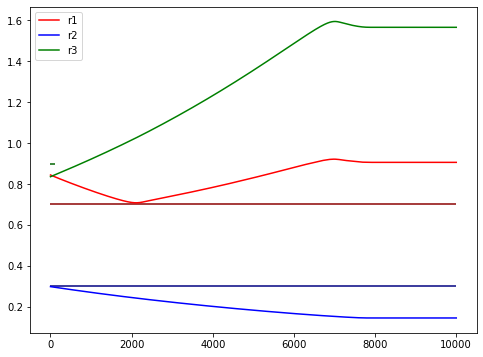

In [420]:
data_shape = torch.zeros(20, 100, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 100 reps, 20 steps

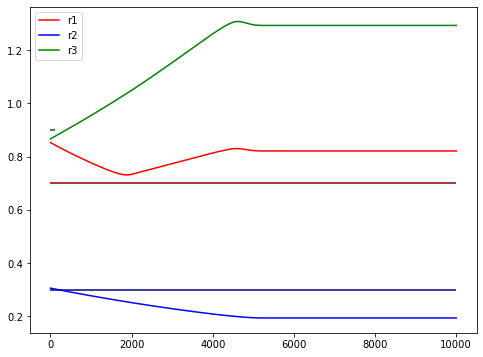

In [421]:
data_shape = torch.zeros(100, 20, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 100 reps, 100 steps

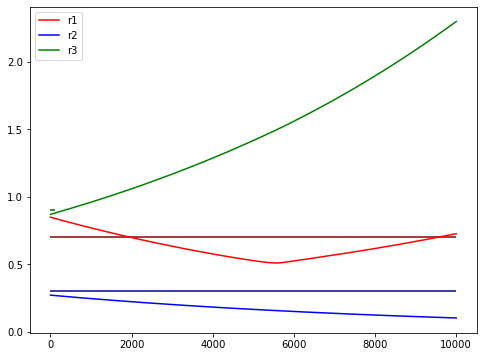

In [422]:
data_shape = torch.zeros(100, 100, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 1000 reps, 1000 steps

In [125]:
data_shape = torch.zeros(1000, 1000, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

KeyboardInterrupt: 

### Vectorized Model (used for inference)

In [324]:
def lotka_volterra_1(data, batch_size=None):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -1.25, -.15]), .1).to_event(1),
    )

    ## Starting points
    
    
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        s_start = torch.tensor([[10., 10.]]*num_sequences)
        for t in pyro.markov(range(max_length)):
            print(f"s {s_start}")
            print(f"rates {rates}")
                
            rates_matrix = torch.stack([rates[0] * pyro.ops.indexing.Vindex(s_start)[..., :, 0], 
                                           rates[1] * pyro.ops.indexing.Vindex(s_start)[..., :, 0] * pyro.ops.indexing.Vindex(s_start)[..., :, 1],
                                           rates[2] * pyro.ops.indexing.Vindex(s_start)[..., :, 1]], axis = 1)
            print(f"rates matrix {rates_matrix}")
            #with sample_plate:
            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(rates_matrix),
                    infer={"enumerate": "parallel"},
            )
            print(f"x sample {x}")
            transition = torch.tensor([[ 1,  0],
                  [-1,  1],
                  [ 0, -1]])
            update = transition[x]
            if s_start.shape not in [torch.Size([1,2]), torch.Size([2]), torch.Size([2,2])]:
                s_start = s_start.reshape(update.shape)
            print(f"update shape {update.shape}")
            print(f"s_start shape {s_start.shape}")
            
            with sample_plate:
                
                print(pyro.sample(
                    "test_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                ).shape)
                print(data[batch, t].shape)
                pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            print(" ")
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)



In [325]:
hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(lotka_volterra_1, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)
elbo.loss(lotka_volterra_1, hmm_guide, temp) ## Ensure model compiles

s tensor([[10., 10.],
        [10., 10.]])
rates tensor([0.8743, 0.3109, 0.8882])
rates matrix tensor([[ 8.7432, 31.0922,  8.8823],
        [ 8.7432, 31.0922,  8.8823]])
x sample tensor([[2, 0],
        [0, 1]])
update shape torch.Size([2, 2, 2])
s_start shape torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2, 2])
 
s tensor([[[10.,  9.],
         [11., 10.]],

        [[11., 10.],
         [ 9., 11.]]])
rates tensor([0.8743, 0.3109, 0.8882])
rates matrix tensor([[[ 8.7432,  9.6175],
         [27.9829, 34.2014],
         [ 7.9941,  8.8823]],

        [[ 9.6175,  7.8689],
         [34.2014, 30.7812],
         [ 8.8823,  9.7706]]])
x sample tensor([[1, 1, 0],
        [0, 1, 0]])


RuntimeError: shape '[2, 3, 2]' is invalid for input of size 8
Trace Shapes:    
 Param Sites:    
Sample Sites:    
   rates dist | 3
        value | 3
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

## Inference

In [26]:
rate_results = infer_rates(lotka_volterra_0, temp, learning_rate=.0001, num_steps = 1000)

ValueError: only one element tensors can be converted to Python scalars
 Trace Shapes:               
  Param Sites:               
 Sample Sites:               
   sample dist            |  
         value          2 |  
sequences dist            |  
         value         20 |  
    x_0_0 dist            |  
         value   3 1 1  1 |  
    y_0_0 dist 3 1 1 1  2 |  
         value 3 1 1 1  2 |  
    d_0_0 dist   3 1 1  1 | 2
         value   3 1 1  1 | 2

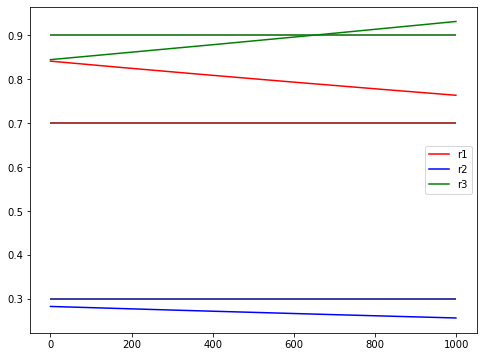

In [12]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,1000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,1000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,1000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 1000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 1000,color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 1000,color = "darkgreen")

plt.legend()

## Workable examples

In [62]:
import torch
import pyro

# data = torch.tensor([[[10.9915,  9.9980, 10.0029],
#          [10.9792, 10.0190, 11.0013],
#          [11.9798, 10.0281, 10.9844],
#          [11.9864, 10.0178, 11.9636],
#          [11.9791, 10.0111, 12.9479],
#          [12.9784,  9.9971, 12.9429],
#          [12.9844,  9.9968, 13.9576],
#          [13.9950,  9.9862, 13.9662],
#          [13.9851,  9.9806, 14.9800]],

#         [[10.9924, 10.0120,  9.9946],
#          [10.9949, 11.0098,  9.9916],
#          [12.0087, 11.0148, 10.0069],
#          [12.0109, 11.0124, 11.0090],
#          [12.0299, 12.0056, 11.0012],
#          [12.0322, 12.9978, 11.0013],
#          [12.0273, 13.9908, 11.0110],
#          [12.0199, 13.9760, 12.0274],
#          [13.0021, 13.9667, 12.0194]],

#         [[10.0110,  9.9978, 11.0101],
#          [11.0041,  9.9873, 11.0155],
#          [10.9992,  9.9824, 12.0085],
#          [12.0218,  9.9913, 11.9981],
#          [12.0341,  9.9903, 12.9941],
#          [13.0320,  9.9898, 12.9641],
#          [13.0294,  9.9919, 13.9693],
#          [14.0283,  9.9874, 13.9610],
#          [14.0334,  9.9912, 14.9647]],

#         [[10.9901, 10.0050,  9.9998],
#          [11.9909, 10.0130, 10.0088],
#          [13.0000, 10.0105,  9.9982],
#          [14.0220, 10.0119,  9.9914],
#          [14.0181, 10.0044, 10.9915],
#          [15.0204,  9.9897, 10.9864],
#          [15.0125,  9.9888, 11.9793],
#          [15.0039,  9.9820, 12.9838],
#          [16.0207,  9.9937, 12.9904]],

#         [[10.9960, 10.0221, 10.0036],
#          [11.9814, 10.0106, 10.0011],
#          [11.9768, 10.9957,  9.9973],
#          [11.9831, 10.9929, 10.9996],
#          [11.9816, 10.9941, 11.9998],
#          [11.9728, 11.9895, 11.9986],
#          [11.9643, 12.9964, 12.0039],
#          [12.9711, 13.0104, 11.9892],
#          [12.9613, 13.0284, 13.0069]]])


def model_1(data, batch_size=None):
    
    num_sequences, max_length, data_dim = data.shape
    # r1 = pyro.sample(
    #     "r1",
    #     pyro.distributions.Normal(torch.tensor(.6), .1).to_event(1),
    # )
    # r2 = pyro.sample(
    #     "r2",
    #     pyro.distributions.Normal(torch.tensor(.3), .1).to_event(1),
    # )
    # r3 = pyro.sample(
    #     "r3",
    #     pyro.distributions.Normal(torch.tensor(.9), .1).to_event(1),
    # )

    ## Rate priors
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -1.25, -.15]), .1).to_event(1),
    )
    # rates = torch.tensor([r1, r2, r3])
    ## Starting points
    s_start = torch.tensor([10., 10., 10.])
    
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:

        for t in pyro.markov(range(max_length)):

            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(rates),
                    infer={"enumerate": "parallel"},
                )

            ## Define update matrix
            update = torch.zeros(tuple(torch.cat((torch.tensor(x.shape[:-1]), torch.tensor([3])))))
            
            ## Update first run without enumeration
            if len(x.shape) == 2:
                update[torch.arange(len(update)), torch.flatten(x).long()] = 1.
            ## Update second run with enumeration. Cycles between 4 and 5 dimension tensor
            elif len(x.shape) == 4:
                update[torch.arange(len(update)), 0, 0,torch.flatten(x).long()] = 1.
            else:
                update[torch.arange(len(update)), 0, 0,0,torch.flatten(x).long()] = 1.
            
            ## Ensure `s_start` shape matches `update` matrix dimension.
            ## Enumeration run cycles between 4 and 5 dimensions, 
            ## `s_start` changes dimensions when combined.
            if s_start.shape != torch.Size([3]):
                s_start = s_start.reshape(update.shape)

            with sample_plate:
                sample = pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)
            

hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model_1, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)
elbo.loss(model_1, hmm_guide, data) ## Ensure model compiles

rates = list()

## Infer rates
optim = pyro.optim.Adam({'lr': .0001})
svi = pyro.infer.SVI(model_1, hmm_guide, optim, elbo)
for step in range(10000):
    svi.step(data)
    for key, value in pyro.get_param_store().items():
        rates.append(value)
    if step %100 == 0:
        
        print(f"Loss: {svi.evaluate_loss(data)}")
        for key, value in pyro.get_param_store().items():    
            print(f"{key}:\n{value}\n")


Loss: 100227360.0
AutoDelta.rates:
tensor([0.8635, 0.2920, 0.8685], grad_fn=<AddBackward0>)

Loss: 100227360.0
AutoDelta.rates:
tensor([0.8550, 0.2891, 0.8772], grad_fn=<AddBackward0>)

Loss: 100227352.0
AutoDelta.rates:
tensor([0.8468, 0.2863, 0.8858], grad_fn=<AddBackward0>)

Loss: 100227360.0
AutoDelta.rates:
tensor([0.8388, 0.2835, 0.8943], grad_fn=<AddBackward0>)

Loss: 100227352.0
AutoDelta.rates:
tensor([0.8311, 0.2809, 0.9029], grad_fn=<AddBackward0>)

Loss: 100227352.0
AutoDelta.rates:
tensor([0.8237, 0.2783, 0.9113], grad_fn=<AddBackward0>)

Loss: 100227344.0
AutoDelta.rates:
tensor([0.8166, 0.2757, 0.9197], grad_fn=<AddBackward0>)

Loss: 100227344.0
AutoDelta.rates:
tensor([0.8097, 0.2733, 0.9280], grad_fn=<AddBackward0>)

Loss: 100227344.0
AutoDelta.rates:
tensor([0.8031, 0.2709, 0.9362], grad_fn=<AddBackward0>)

Loss: 100227336.0
AutoDelta.rates:
tensor([0.7967, 0.2685, 0.9444], grad_fn=<AddBackward0>)

Loss: 100227344.0
AutoDelta.rates:
tensor([0.7905, 0.2663, 0.9525], gr

## New Data Generation

In [28]:
def model_1(data, batch_size=None):
    
    num_sequences, max_length, data_dim = data.shape
    
    #with pyro.plate("rate_sample"):
    ## Rate priors
    r1 = pyro.sample(
        "r1",
        pyro.distributions.Normal(torch.tensor(.6), .01),
    )
    r2 = pyro.sample(
        "r2",
        pyro.distributions.Normal(torch.tensor(.3), .01),
    )
    r3 = pyro.sample(
        "r3",
        pyro.distributions.Normal(torch.tensor(.9), .01),
    )

    
    ## Starting points
    s_start = torch.tensor([10., 10., 10.])
    
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        x = 0
        
        for t in pyro.markov(range(1, max_length)):

            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(torch.tensor([r1, r2, r3])),
                    infer={"enumerate": "parallel"},
                )

            
            ## Define update matrix
            update = torch.zeros(tuple(torch.cat((torch.tensor(x.shape[:-1]), torch.tensor([3])))))
            
            ## Update first run without enumeration
            if len(x.shape) == 2:
                update[torch.arange(len(update)), torch.flatten(x).long()] = 1.
            ## Update second run with enumeration. Cycles between 4 and 5 dimension tensor
            elif len(x.shape) == 4:
                update[torch.arange(len(update)), 0, 0,torch.flatten(x).long()] = 1.
            else:
                update[torch.arange(len(update)), 0, 0,0,torch.flatten(x).long()] = 1.
            
            ## Ensure `s_start` shape matches `update` matrix dimension.
            ## Enumeration run cycles between 4 and 5 dimensions, 
            ## `s_start` changes dimensions when combined.
            if s_start.shape != torch.Size([3]):
                s_start = s_start.reshape(update.shape)

            with sample_plate:
                #print(data[batch, t])
                sample = pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)
            

hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model_1, expose=["r1", "r2", "r3"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)
elbo.loss(model_1, hmm_guide, test) ## Ensure model compiles

## Infer rates
optim = pyro.optim.Adam({'lr': .01})#, 'betas' : (0.95, 0.999)})
svi = pyro.infer.SVI(model_1, hmm_guide, optim, elbo)
for step in range(10000):
    loss = svi.step(test)
    if step %100 == 0:
        print(loss)
        for key, value in pyro.get_param_store().items():    
            print(f"{key}:\n{value}\n")

## Check inferred rate values   
for key, value in pyro.get_param_store().items():    
    print(f"{key}:\n{value}\n")

66663755776.0
AutoDelta.r1:
0.6099592447280884

AutoDelta.r2:
0.2919798791408539

AutoDelta.r3:
0.8930048942565918

66663755776.0
AutoDelta.r1:
0.6000280380249023

AutoDelta.r2:
0.3000393807888031

AutoDelta.r3:
0.9000186920166016

66663755776.0
AutoDelta.r1:
0.5999998450279236

AutoDelta.r2:
0.3000001609325409

AutoDelta.r3:
0.9000001549720764

66663755776.0
AutoDelta.r1:
0.6000000238418579

AutoDelta.r2:
0.30000004172325134

AutoDelta.r3:
0.9000000953674316

66663755776.0
AutoDelta.r1:
0.6000000834465027

AutoDelta.r2:
0.30000004172325134

AutoDelta.r3:
0.8999999761581421

66663755776.0
AutoDelta.r1:
0.5999999642372131

AutoDelta.r2:
0.30000004172325134

AutoDelta.r3:
0.8999999761581421



KeyboardInterrupt: 

In [766]:
temp = model_1(data)
test = torch.stack(temp)

In [767]:
test

tensor([[[10., 10., 11.],
         [10., 10., 11.],
         [10., 10., 11.],
         ...,
         [10., 10., 11.],
         [10., 10., 11.],
         [11., 10., 10.]],

        [[10., 10., 12.],
         [11., 10., 11.],
         [11., 10., 11.],
         ...,
         [11., 10., 11.],
         [10., 10., 12.],
         [12., 10., 10.]],

        [[11., 10., 12.],
         [11., 11., 11.],
         [11., 10., 12.],
         ...,
         [11., 10., 12.],
         [10., 10., 13.],
         [13., 10., 10.]],

        ...,

        [[44., 29., 54.],
         [43., 25., 59.],
         [54., 26., 47.],
         ...,
         [48., 20., 59.],
         [44., 29., 54.],
         [44., 23., 60.]],

        [[44., 29., 55.],
         [44., 25., 59.],
         [55., 26., 47.],
         ...,
         [49., 20., 59.],
         [44., 29., 55.],
         [44., 24., 60.]],

        [[44., 30., 55.],
         [45., 25., 59.],
         [56., 26., 47.],
         ...,
         [50., 20., 59.],
        

In [741]:
s_start = torch.tensor([[10., 10., 10.]])

In [742]:
s_start.reshape([100, 3])

RuntimeError: shape '[100, 3]' is invalid for input of size 3

In [743]:
s_start.shape

torch.Size([1, 3])

In [53]:
import torch
import pyro

## Define Model
def model_0(sequences, num_sequences, max_length, batch_size=None):
    
    collect = list()
    
    temp, temp2, data_dim = sequences.shape

    rates = torch.tensor([.7, .3, .9])

        # s_start = pyro.sample(
        #     "start", 
        #     pyro.distributions.Normal(10, 0.01).expand([3]).to_event(1))
        # print(s_start)
    # s_start = torch.tensor([10., 10., 10.])
    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    for i in pyro.plate("sequences", num_sequences, batch_size):
        temp_list = list()
        s_start = torch.tensor([10., 10., 10.])
        for t in pyro.markov(torch.arange(max_length)):

            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates),
                        infer={"enumerate": "parallel"},
                    )
            
            ## Update tensor
            update = torch.zeros(3)
            update[x] = 1
            with sample_plate:
                
                ## Observed sample
                obs = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01)
                )
                #print(obs)
                temp_list.append(list(obs))
            
            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), s_start + update, event_dim=1)
            
        collect.append(torch.tensor(temp_list))
    return collect
## Inference


In [56]:
temp = model_0(torch.zeros(20, 20, 3), 20, 20)
data = torch.stack(temp)

In [52]:
torch.zeros(1000, 1000, 3).shape

torch.Size([1000, 1000, 3])

In [64]:
big_data = data

## Define Models

### Unvectorized Loop Model (used for data gen)

In [4]:
## Define Model
def model_0(sequences):
    
    collect = list()
    
    num_sequences, max_length, data_dim = sequences.shape
    
    ## Define true rates
    # rates = torch.tensor([.7, .3, .9])
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -1.25, -.15]), .1).to_event(1),
    )

    ## Loop over sequences
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    for i in pyro.plate("sequences", num_sequences):
        temp_list = list()
        s_start = torch.tensor([10., 10., 10.])
        for t in pyro.markov(torch.arange(max_length)):

            x = pyro.sample(
                        "x_{}_{}".format(t, i),
                        pyro.distributions.Categorical(rates),
                        infer={"enumerate": "parallel"},
                    )
            print(x.shape)
            print(x)
            ## Update tensor
            update = torch.zeros(3)
            update[x] = 1
            print(update)
            print(s_start + update)
            with sample_plate:
                
                print(pyro.sample(
                    "meh_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    #obs=sequences[i, t]
                ).shape)
                print(sequences[i, t].shape)
                ## Observed sample
                obs = pyro.sample(
                    "y_{}_{}".format(t, i),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=sequences[i, t]
                )
                #print(obs)
                temp_list.append(list(obs))
            
            ## True update
            s_start = pyro.deterministic("d_{}_{}".format(t, i), s_start + update, event_dim=1)
            print(" ")
        collect.append(torch.tensor(temp_list))
    return collect


In [542]:
index = torch.tensor([[[0]],

        [[1]],

        [[2]]])

In [543]:
update = torch.zeros(3)


In [546]:
update[index] = 1.

In [547]:
update

tensor([1., 1., 1.])

In [541]:
hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model_0, expose=["rates"]))
pyro.clear_param_store()
elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_0, hmm_guide, data) ## Ensure model compiles

torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([10., 10., 11.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([10., 10., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(1)
tensor([0., 1., 0.])
tensor([10., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([11., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([12., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([12., 11., 13.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([13., 11., 13.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([14., 11., 13.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([15., 11., 13.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(1)
tensor([0., 1., 0.])
tensor([15., 12., 

5692781.0

### Vectorized Model (used for inference)

In [8]:
def model_1(data, batch_size=None):
    
    num_sequences, max_length, data_dim = data.shape

    ## Rate priors (to infer)
    rates = pyro.sample(
        "rates",
        pyro.distributions.LogNormal(torch.tensor([-.15, -1.25, -.15]), .1).to_event(1),
    )

    ## Starting points
    
    
    sample_plate = pyro.plate("sample", data_dim, dim=-1)
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        s_start = torch.tensor([10., 10., 10.])
        for t in pyro.markov(range(max_length)):

            x = pyro.sample(
                    "x_{}".format(t),
                    pyro.distributions.Categorical(rates),
                    infer={"enumerate": "parallel"},
                )
            print(x.shape)
            ## Define update matrix
            update = torch.zeros(tuple(torch.cat((torch.tensor(x.shape[:-1]), torch.tensor([3])))))
            
            ## Update first run without enumeration
            if len(x.shape) == 2:
                update[torch.arange(len(update)), torch.flatten(x).long()] = 1.
            ## Update second run with enumeration. Cycles between 4 and 5 dimension tensor
            elif len(x.shape) == 4:
                update[torch.arange(len(update)), 0, 0,torch.flatten(x).long()] = 1.
            else:
                update[torch.arange(len(update)), 0, 0,0,torch.flatten(x).long()] = 1.
            
            ## Ensure `s_start` shape matches `update` matrix dimension.
            ## Enumeration run cycles between 4 and 5 dimensions, 
            ## `s_start` changes dimensions when combined.
            if s_start.shape != torch.Size([3]):
                s_start = s_start.reshape(update.shape)

            with sample_plate:
                pyro.sample(
                    "y_{}".format(t),
                    pyro.distributions.Normal(s_start + update, .01),
                    obs=data[batch, t]
                )
            
            ## Update s_start for next step
            s_start = pyro.deterministic("d_{}".format(t), s_start + update)


## Generate Data

In [5]:
data_shape = torch.zeros(2, 10, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([11., 10., 10.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([11., 10., 11.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([11., 10., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(1)
tensor([0., 1., 0.])
tensor([11., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([12., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([13., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(0)
tensor([1., 0., 0.])
tensor([14., 11., 12.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([14., 11., 13.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([14., 11., 14.])
torch.Size([3])
torch.Size([3])
 
torch.Size([])
tensor(2)
tensor([0., 0., 1.])
tensor([14., 11., 

In [6]:
data.shape

torch.Size([2, 10, 3])

### Save Data

In [435]:
with open('../data/test_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Confirm rates make sense

#### S1

(array([3., 1., 6., 5., 0., 1., 1., 2., 0., 1.]),
 array([13.998356, 14.798813, 15.599271, 16.399729, 17.200186, 18.000643,
        18.8011  , 19.601557, 20.402016, 21.202473, 22.00293 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

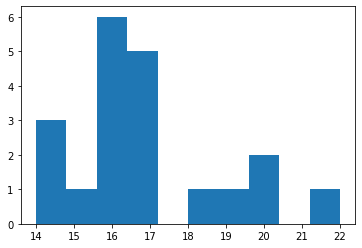

In [6]:
fig, ax = plt.subplots()

ax.hist(np.array(data[:, 19, 0]), bins = 10)

#### S2

(array([1., 2., 0., 6., 0., 4., 6., 0., 0., 1.]),
 array([ 9.990631, 10.589281, 11.18793 , 11.78658 , 12.385229, 12.983879,
        13.582529, 14.181178, 14.779828, 15.378477, 15.977127],
       dtype=float32),
 <BarContainer object of 10 artists>)

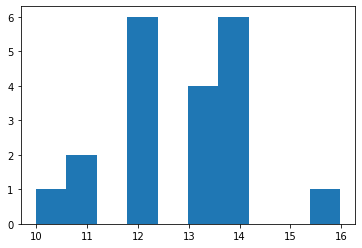

In [7]:
fig, ax = plt.subplots()

ax.hist(np.array(data[:, 19, 1]), bins = 10)

#### S3

In [2]:
import numpy as np

In [3]:
2**np.array([-.15, -6., -1.5])

array([0.90125046, 0.015625  , 0.35355339])

In [4]:
2**np.array([-.15, -4., -1.])

array([0.90125046, 0.0625    , 0.5       ])

(array([2., 1., 7., 0., 2., 0., 0., 3., 3., 2.]),
 array([15.9991045, 16.699142 , 17.399181 , 18.099218 , 18.799257 ,
        19.499296 , 20.199333 , 20.899372 , 21.599411 , 22.299448 ,
        22.999487 ], dtype=float32),
 <BarContainer object of 10 artists>)

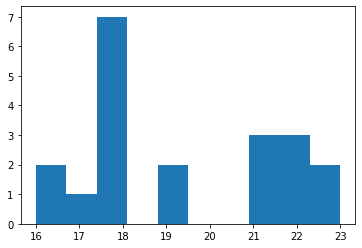

In [84]:
fig, ax = plt.subplots()

ax.hist(np.array(data[:, 19, 2]), bins = 10)

## Inference (!)

In [502]:
def infer_rates(model, observations, learning_rate=.001, num_steps = 1000, beta0=.9, beta1=.99):
    
    hmm_guide = pyro.infer.autoguide.AutoDelta(pyro.poutine.block(model, expose=["rates"]))
    pyro.clear_param_store()
    elbo = pyro.infer.TraceEnum_ELBO(max_plate_nesting=3)
    elbo.loss(model, hmm_guide, observations) ## Ensure model compiles

    rates = list()

    ## Infer rates
    optim = pyro.optim.Adam({"lr": learning_rate, "betas" : (beta0, beta1)})
    svi = pyro.infer.SVI(model, hmm_guide, optim, elbo)
    for step in range(num_steps):
        svi.step(observations)
        for key, value in pyro.get_param_store().items():
            rates.append(value)
#         if step %100 == 0:

#             print(f"Loss: {svi.evaluate_loss(data)}")
#             for key, value in pyro.get_param_store().items():    
#                 print(f"{key}:\n{value}\n")
    
    rates = np.array([x.detach().numpy() for x in rates])
    return rates


In [505]:
rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 1000)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,1000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,1000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,1000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 1000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 1000,color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 1000,color = "darkgreen")

plt.legend()

### Try some different data sizes

#### 20 reps, 100 steps

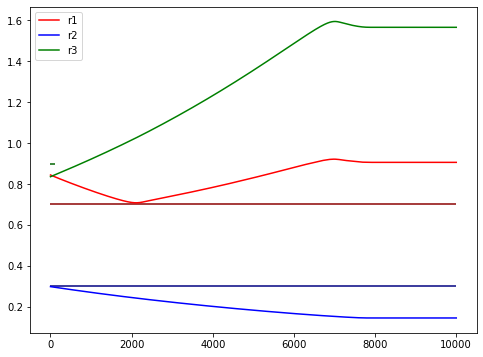

In [420]:
data_shape = torch.zeros(20, 100, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 100 reps, 20 steps

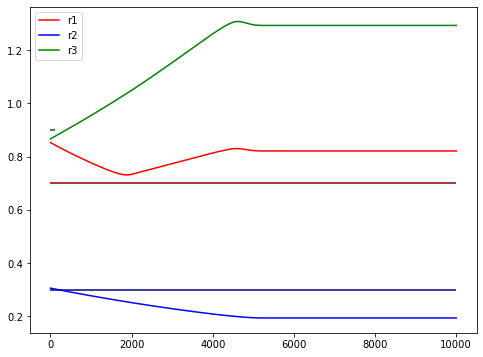

In [421]:
data_shape = torch.zeros(100, 20, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 100 reps, 100 steps

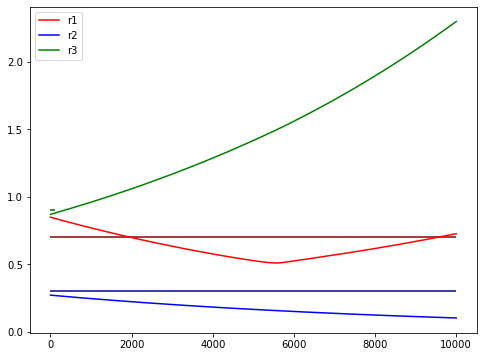

In [422]:
data_shape = torch.zeros(100, 100, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

#### 1000 reps, 1000 steps

In [125]:
data_shape = torch.zeros(1000, 1000, 3)
data_gen = model_0(data_shape)
data = torch.stack(data_gen)

rate_results = infer_rates(model_1, data, learning_rate=.0001, num_steps = 10000)

fig, ax = plt.subplots(figsize = (8,6))

ax.plot(np.arange(0,10000), rate_results[:, 0], color = "red", label = "r1")
ax.plot(np.arange(0,10000), rate_results[:, 1], color = "blue", label = "r2")
ax.plot(np.arange(0,10000), rate_results[:, 2], color = "green", label = "r3")

ax.hlines(y = .7, xmin = 0, xmax = 10000, color = "darkred")
ax.hlines(y = .3, xmin = 0, xmax = 10000, color = "navy")
ax.hlines(y = .9, xmin = 0, xmax = 100, color = "darkgreen")

plt.legend()

KeyboardInterrupt: 